In [3]:
import umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from Model.model import MODEL, MODEL_RobustText, ECGTextFusion
from train import train_loop
from teste import test_model
from utils.dataset import  PTBXLDataset, PTBXLDataset_with_prompt, PTBXLDataset_with_generated_prompt,PTBXLDatasetWithTextEmbeddingNPY
from utils.utils import get_smallest_loss_model_path, init_log
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import torch
import plotly.express as px
from sklearn.metrics import silhouette_score
from Model.ECG_encoder.resnet1d import resnet18_1d
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/giovanidl/miniconda3/envs/gienv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [4]:
train_dataset_robust_text = PTBXLDatasetWithTextEmbeddingNPY(
        data_dir="/home/giovanidl/Datasets/PTBXL",
        text_embedding_path="/home/giovanidl/doutorado/prelim/cache/npy_cache/robust_text_embeddings_train.npy",
        split="train",
        sampling_rate=500
    )
val_dataset_robust_text = PTBXLDatasetWithTextEmbeddingNPY(
    data_dir="/home/giovanidl/Datasets/PTBXL",
    text_embedding_path="/home/giovanidl/doutorado/prelim/cache/npy_cache/robust_text_embeddings_val.npy",
    split="val",
    sampling_rate=500
)

test_dataset_robust_text = PTBXLDatasetWithTextEmbeddingNPY(
    data_dir="/home/giovanidl/Datasets/PTBXL",
    text_embedding_path="/home/giovanidl/doutorado/prelim/cache/npy_cache/robust_text_embeddings_test.npy",
    split="test",
    sampling_rate=500
    )

In [5]:
train_loader_robust_text = DataLoader(train_dataset_robust_text, batch_size=16, shuffle=False)
val_loader_robust_text = DataLoader(val_dataset_robust_text, batch_size=16, shuffle=False)
test_loader_robust_text = DataLoader(test_dataset_robust_text, batch_size=16, shuffle=False)


In [6]:
def load_ecg_encoder(model_checkpoint_path, model_checkpoint_name):
    ckpt = torch.load(
        f"{model_checkpoint_path}/{model_checkpoint_name}",
        map_location=device
    )

    state_dict = ckpt["model_state_dict"]

    # manter só pesos do ecg_encoder e remover o prefixo
    ecg_state_dict = {
        k.replace("ecg_encoder.", ""): v
        for k, v in state_dict.items()
        if k.startswith("ecg_encoder.")
    }

    ecg_encoder = resnet18_1d(
        in_channels=12,
        projection_size=512
    ).to(device)

    ecg_encoder.load_state_dict(ecg_state_dict)
    ecg_encoder.eval()

    return ecg_encoder

In [7]:
def extract_embeddings_ecg(ecg_encoder, val_loader_robust_text):    
    all_embeddings_ecg = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader_robust_text:
            # Ajuste se o batch tiver mais elementos
            ecg, embeddings, targets = batch  
            ecg = ecg.to(device)
            ecg_features = ecg_encoder(ecg)
            ecg_features = ecg_features.to(device)
            targets = targets.to(device)
            
            # One-hot -> índice da classe
            labels = torch.argmax(targets, dim=1)
            all_embeddings_ecg.append(ecg_features.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_embeddings_ecg = np.vstack(all_embeddings_ecg)

    all_labels = np.concatenate(all_labels)
    return all_embeddings_ecg, all_labels

In [8]:
def extract_embeddings_ecg_text(ecg_encoder, val_loader_robust_text):    
    all_embeddings_ecg = []
    all_embeddings_ecg_text = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader_robust_text:
            # Ajuste se o batch tiver mais elementos
            ecg, embeddings, targets = batch  
            ecg = ecg.to(device)
            ecg_features = ecg_encoder(ecg)
            ecg_features = ecg_features.to(device)
            embeddings = embeddings.to(device)
            targets = targets.to(device)
            
            concat_embeddings = torch.cat((ecg_features, embeddings), dim=1)

            # One-hot -> índice da classe
            labels = torch.argmax(targets, dim=1)
            all_embeddings_ecg.append(ecg_features.cpu().numpy())
            
            all_embeddings_ecg_text.append(concat_embeddings.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_embeddings_ecg = np.vstack(all_embeddings_ecg)
    all_embeddings_ecg_text = np.vstack(all_embeddings_ecg_text)

    all_labels = np.concatenate(all_labels)
    return all_embeddings_ecg_text, all_labels

In [9]:
def generate_umap_plot(embeddings, labels, save_path):
    
    sil_score = silhouette_score(
        embeddings,
        labels,
        metric="cosine"
    )

    print(f"Silhouette Score (Cosine): {sil_score:.4f}")
    reducer = umap.UMAP(
        n_neighbors=20,
        n_components=2,
        min_dist=0.1,
        metric="cosine",
        random_state=42)
    embedding_umap = reducer.fit_transform(embeddings)
    df_umap = pd.DataFrame({
        "x": embedding_umap[:, 0],
        "y": embedding_umap[:, 1],
        "label": labels
    })
    label_map = {
    0: "NORM",
    1: "MI",
    2: "STTC",
    3: "CD",
    4: "HYP"
    }

    df_umap["label_name"] = df_umap["label"].map(label_map)
    
    
    fig = px.scatter(
        df_umap,
        x="x",
        y="y",
        color="label_name",   # ou "label"
        opacity=0.7,
        title=f"UMAP of ECG Embeddings (silhouette_score={sil_score:.4f})",
    )

    fig.show()

# UNIMODAL - ECG

### MLP - (ecg_emb) -> 256 -> 64 -> 5

In [10]:
generate_umap_plot(*extract_embeddings_ecg(load_ecg_encoder(
    model_checkpoint_path="/home/giovanidl/doutorado/prelim/checkpoints/ecg/",
    model_checkpoint_name="MLP256_64_Epoch_23_20260128_185652.pt"
    ), val_loader_robust_text), save_path="umap_ecg.html")

Silhouette Score (Cosine): 0.2802


/home/giovanidl/miniconda3/envs/gienv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### MLP - (ecg_emb) -> 256 -> 5

In [11]:

generate_umap_plot(*extract_embeddings_ecg(load_ecg_encoder(
    model_checkpoint_path="/home/giovanidl/doutorado/prelim/checkpoints/ecg/",
    model_checkpoint_name="MLP256_Epoch_12_20260128_165950.pt"
    ), val_loader_robust_text), save_path="umap_ecg.html")

Silhouette Score (Cosine): 0.2870


/home/giovanidl/miniconda3/envs/gienv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



# Multimodal - ECG + Robust Text

### MLP - (ecg_emb + text_emb) -> 512 -> 256 -> 64 -> 5

In [12]:
generate_umap_plot(*extract_embeddings_ecg_text(load_ecg_encoder(
    model_checkpoint_path="/home/giovanidl/doutorado/prelim/checkpoints/ecgtext/",
    model_checkpoint_name="MLP512_256_64_Epoch_31_20260128_202745.pt"
    ), val_loader_robust_text), save_path="umap_ecg.html")

Silhouette Score (Cosine): 0.2399


/home/giovanidl/miniconda3/envs/gienv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



### MLP - (ecg_emb + text_emb) -> 512 -> 256 -> 5

In [13]:
generate_umap_plot(*extract_embeddings_ecg_text(load_ecg_encoder(
    model_checkpoint_path="/home/giovanidl/doutorado/prelim/checkpoints/ecgtext/",
    model_checkpoint_name="MLP512_256_Epoch_23_20260128_190916.pt"
    ), val_loader_robust_text), save_path="umap_ecg.html")

Silhouette Score (Cosine): 0.2430


/home/giovanidl/miniconda3/envs/gienv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



# Multimodal - LLM

### MLP - (ecg_emb + text_emb) -> 512 -> 256 -> 64 -> 5

In [14]:
generate_umap_plot(*extract_embeddings_ecg_text(load_ecg_encoder(
    model_checkpoint_path="/home/giovanidl/doutorado/prelim/checkpoints/ecgllm/",
    model_checkpoint_name="MLP512_256_64_Epoch_20_20260128_184033.pt"
    ), val_loader_robust_text), save_path="umap_ecg.html")

Silhouette Score (Cosine): 0.1841


/home/giovanidl/miniconda3/envs/gienv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



### MLP - (ecg_emb + text_emb) -> 512 -> 256 -> 5

In [15]:
generate_umap_plot(*extract_embeddings_ecg_text(load_ecg_encoder(
    model_checkpoint_path="/home/giovanidl/doutorado/prelim/checkpoints/ecgllm/",
    model_checkpoint_name="MLP512_256_Epoch_21_20260128_185343.pt"
    ), val_loader_robust_text), save_path="umap_ecg.html")

Silhouette Score (Cosine): 0.1869


/home/giovanidl/miniconda3/envs/gienv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [16]:
a = list(val_dataset_robust_text)

In [17]:
len(a[0][0][0])

5000

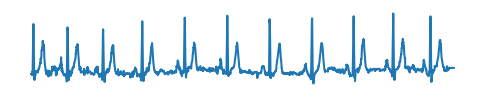

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 1))
plt.plot(a[1][0][0])
plt.axis("off")
plt.savefig("ecg_signal_example.png", bbox_inches='tight', pad_inches=0)

In [19]:
all_embeddings_1, all_labels_1 = extract_embeddings_ecg(load_ecg_encoder(
    model_checkpoint_path="/home/giovanidl/doutorado/prelim/checkpoints/ecg/",
    model_checkpoint_name="MLP256_64_Epoch_23_20260128_185652.pt"
    ), val_loader_robust_text)

all_embeddings_2, all_labels_2 = extract_embeddings_ecg(load_ecg_encoder(
    model_checkpoint_path="/home/giovanidl/doutorado/prelim/checkpoints/ecg/",
    model_checkpoint_name="MLP256_Epoch_12_20260128_165950.pt"
    ), val_loader_robust_text)

all_embeddings_3, all_labels_3 = extract_embeddings_ecg_text(load_ecg_encoder(
    model_checkpoint_path="/home/giovanidl/doutorado/prelim/checkpoints/ecgtext/",
    model_checkpoint_name="MLP512_256_64_Epoch_31_20260128_202745.pt"
    ), val_loader_robust_text)

all_embeddings_4, all_labels_4 = extract_embeddings_ecg_text(load_ecg_encoder(
    model_checkpoint_path="/home/giovanidl/doutorado/prelim/checkpoints/ecgtext/",
    model_checkpoint_name="MLP512_256_Epoch_23_20260128_190916.pt"
    ), val_loader_robust_text)

all_embeddings_5, all_labels_5 = extract_embeddings_ecg_text(load_ecg_encoder(
    model_checkpoint_path="/home/giovanidl/doutorado/prelim/checkpoints/ecgllm/",
    model_checkpoint_name="MLP512_256_64_Epoch_20_20260128_184033.pt"
    ), val_loader_robust_text)

all_embeddings_6, all_labels_6 = extract_embeddings_ecg_text(load_ecg_encoder(
    model_checkpoint_path="/home/giovanidl/doutorado/prelim/checkpoints/ecgllm/",
    model_checkpoint_name="MLP512_256_Epoch_21_20260128_185343.pt"
    ), val_loader_robust_text)

In [20]:
import pandas as pd
import numpy as np

def build_umap_df(embeddings_list, labels_list, subset_names):
    dfs = []

    for emb, labels, name in zip(embeddings_list, labels_list, subset_names):
        df_i = pd.DataFrame({
            "umap_x": emb[:, 0],
            "umap_y": emb[:, 1],
            "label": labels,
            "subset": name
        })
        dfs.append(df_i)

    return pd.concat(dfs, ignore_index=True)

In [52]:
def calc_silhouette_score(embeddings, labels):
    return silhouette_score(embeddings, labels, metric="euclidean")

In [53]:
sil_score_1 = calc_silhouette_score(all_embeddings_1, all_labels_1)
sil_score_2 = calc_silhouette_score(all_embeddings_2, all_labels_2)
sil_score_3 = calc_silhouette_score(all_embeddings_3, all_labels_3)
sil_score_4 = calc_silhouette_score(all_embeddings_4, all_labels_4)
sil_score_5 = calc_silhouette_score(all_embeddings_5, all_labels_5)
sil_score_6 = calc_silhouette_score(all_embeddings_6, all_labels_6)


In [54]:
print(sil_score_1, sil_score_2, sil_score_3, sil_score_4, sil_score_5, sil_score_6)

0.1117447 0.14480123 0.13863066 0.13815409 0.11606122 0.113451585


In [50]:
import plotly.express as px

# df precisa ter, no mínimo:
# - 'umap_x', 'umap_y'  -> coordenadas do UMAP
# - 'label'            -> classes (para a legenda)
# - 'subset'           -> variável que define os 6 subplots
reducer = umap.UMAP(
        n_neighbors=20,
        n_components=2,
        min_dist=0.1,
        metric="cosine",
        random_state=42)
embedding_umap1 = reducer.fit_transform(all_embeddings_1)
embedding_umap2 = reducer.fit_transform(all_embeddings_2)
embedding_umap3 = reducer.fit_transform(all_embeddings_3)
embedding_umap4 = reducer.fit_transform(all_embeddings_4)
embedding_umap5 = reducer.fit_transform(all_embeddings_5)
embedding_umap6 = reducer.fit_transform(all_embeddings_6)



color_map = {
    "NORM": "#1f77b4",   # azul
    "MI": "#d62728",     # vermelho
    "STTC": "#ff7f0e",   # laranja
    "CD": "#9467bd",     # roxo
    "HYP": "#2ca02c"     # verde
}

df_umap = build_umap_df(
    embeddings_list=[embedding_umap1, embedding_umap2, embedding_umap3, embedding_umap4, embedding_umap5, embedding_umap6],
    labels_list=[all_labels_1, all_labels_2, all_labels_3, all_labels_4, all_labels_5, all_labels_6],
    subset_names=[
        f"ECG-Only (D) Silhouette: {sil_score_1.__format__('.4f')}",
        f"ECG-Only (S) Silhouette: {sil_score_2.__format__('.4f')}",
        f"CLIC-DtT (D) Silhouette: {sil_score_3.__format__('.4f')}",
        f"CLIC-DtT (S) Silhouette: {sil_score_4.__format__('.4f')}",
        f"CLIC-LLM (D) Silhouette: {sil_score_5.__format__('.4f')}",
        f"CLIC-LLM (S) Silhouette: {sil_score_6.__format__('.4f')}"]
)   
label_map = {
0: "NORM",
1: "MI",
2: "STTC",
3: "CD",
4: "HYP"
}

df_umap["label_name"] = df_umap["label"].map(label_map)



/home/giovanidl/miniconda3/envs/gienv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [51]:
fig = px.scatter(
    df_umap,
    x="umap_x",
    y="umap_y",
    color="label_name",
    facet_col="subset",
    facet_col_wrap=3,          # 2 linhas x 3 colunas = 6 subplots
    color_discrete_map=color_map,
    category_orders={
        "label_name": ["NORM", "MI", "STTC", "CD", "HYP"]
    },
    height=700,
    width=1200,
    facet_col_spacing=0.01,   # reduz espaço horizontal
    facet_row_spacing=0.05    # reduz espaço vertical
)

# Remove todos os eixos
fig.update_xaxes(visible=False, scaleanchor=None)
fig.update_yaxes(visible=False, scaleanchor=None)
fig.update_traces(
    marker=dict(size=4),
    legendgrouptitle_font_size=60
)

fig.update_xaxes(matches=None)
fig.update_yaxes(matches=None)
# Layout compacto
fig.update_layout(
    margin=dict(l=5, r=5, t=40, b=5),
    legend=dict(
        itemsizing="constant",    #
        itemwidth=40,   
        orientation="h",
        font=dict(size=22),
        title_font=dict(size=22),
        x=0.5,
        y=1.12,
        xanchor="center",
        yanchor="top"
    ),
    legend_title_text="Classe",
)

# Limpa o texto padrão dos facets e usa como caption
fig.for_each_annotation(
    lambda a: a.update(
        text=a.text.split("=")[-1],  # remove "subset="
        font=dict(size=18)
    )
)

fig.show()
fig.write_image("UMAP_ALLPLOTS.pdf")

In [25]:
ECG_results_path = "/home/giovanidl/doutorado/prelim/results/ECG/"
ECGtext_results_path = "/home/giovanidl/doutorado/prelim/results/ECGText/"
ECGllm_results_path = "/home/giovanidl/doutorado/prelim/results/ECGLLM/"

In [55]:
def extract_mean_and_std_from_csv(file_path):
    df_mean = pd.read_csv(f"{file_path}_mean.csv", index_col=0)
    df_std = pd.read_csv(f"{file_path}_std.csv", index_col=0)
    mean_general_value = df_mean.loc['accuracy'].iloc[2]  # média da acurácia
    std_general_value = df_std.loc['accuracy'].iloc[2]   # desvio padrão da acurácia
    mean_macro_avg_value = df_mean.loc['weighted avg'].iloc[2]  # média do F1-score macro
    std_macro_avg_value = df_std.loc['weighted avg'].iloc[2]   # desvio padrão do F1-score macro
    
    return mean_general_value, std_general_value, mean_macro_avg_value, std_macro_avg_value

In [56]:
ecg_metrics_d = extract_mean_and_std_from_csv(f"{ECG_results_path}ECG_256_64mlp_5_1000")
ecg_metrcs_s = extract_mean_and_std_from_csv(f"{ECG_results_path}ECG_256mlp_5_1000")
ecgtext_metrics_d = extract_mean_and_std_from_csv(f"{ECGtext_results_path}ECGText_512_256_64mlp_5_1000")
ecgtext_metrics_s = extract_mean_and_std_from_csv(f"{ECGtext_results_path}ECGText_512_256mlp_5_1000")
ecgllm_metrics_d = extract_mean_and_std_from_csv(f"{ECGllm_results_path}ECGLLM_512_256_64mlp_5_1000")
ecgllm_metrics_s = extract_mean_and_std_from_csv(f"{ECGllm_results_path}ECGLLM_512_256mlp_5_1000")


In [57]:
ecgllm_metrics_d

(0.770154686078253, 0.0032234739916138, 0.7624045832785346, 0.0018534949412248)

In [58]:
import pandas as pd
import plotly.express as px

data = [
    ("ECG-only-S", *ecg_metrcs_s),
    ("ECG-only-D", *ecg_metrics_d),
    ("CLIC-DtT-S",  *ecgtext_metrics_s),
    ("CLIC-DtT-D",  *ecgtext_metrics_d),
    ("CLIC-LLM-S",  *ecgllm_metrics_s),
    ("CLIC-LLM-D",  *ecgllm_metrics_d),
]

df = pd.DataFrame(
    data,
    columns=[
        "model",
        "acc_mean", "acc_std",
        "f1_mean", "f1_std"
    ]
)


In [59]:
model_order = [
    "ECG-only-S", "ECG-only-D",
    "CLIC-DtT-S",  "CLIC-DtT-D",
    "CLIC-LLM-S",  "CLIC-LLM-D",
]
fig_acc = px.bar(
    df,
    x="model",
    y="acc_mean",
    error_y="acc_std",
    category_orders={"model": model_order},
    labels={
        "model": "Model",
        "acc_mean": "General Accuracy"
    },
)

fig_acc.update_layout(
    font=dict(size=16),
    margin=dict(l=40, r=20, t=20, b=40),
)

fig_acc.update_yaxes(range=[0.68, 0.80])
fig_acc.show()
fig_acc.write_image("general_accuracy_barplot.pdf")

In [60]:
df_long = pd.DataFrame({
    "model": df["model"].tolist() * 2,
    "metric": ["Accuracy"] * 6 + ["Macro F1"] * 6,
    "mean": list(df["acc_mean"]) + list(df["f1_mean"]),
    "std":  list(df["acc_std"])  + list(df["f1_std"]),
})

fig = px.bar(
    df_long,
    x="model",
    y="mean",
    error_y="std",
    facet_col="metric",
    category_orders={"model": model_order},
    labels={"mean": "Score", "model": "Model"},
)

fig.update_layout(
    font=dict(size=16),
    margin=dict(l=40, r=20, t=30, b=40),
)

fig.show()
fig.write_image("accuracy_f1_barplot.pdf")


In [61]:
import pandas as pd
import plotly.express as px

df = pd.DataFrame({
    "model": [
        "ECG-only-S", "ECG-only-D",
        "CLIC-DtT-S",  "CLIC-DtT-D",
        "CLIC-LLM-S",  "CLIC-LLM-D",
    ],
    "acc_mean": [
        ecg_metrcs_s[0], ecg_metrics_d[0],
        ecgtext_metrics_s[0], ecgtext_metrics_d[0],
        ecgllm_metrics_s[0], ecgllm_metrics_d[0],
    ],
    "acc_std": [
        ecg_metrcs_s[1], ecg_metrics_d[1],
        ecgtext_metrics_s[1], ecgtext_metrics_d[1],
        ecgllm_metrics_s[1], ecgllm_metrics_d[1],
    ],
    "f1_mean": [
        ecg_metrcs_s[2], ecg_metrics_d[2],
        ecgtext_metrics_s[2], ecgtext_metrics_d[2],
        ecgllm_metrics_s[2], ecgllm_metrics_d[2],
    ],
    "f1_std": [
        ecg_metrcs_s[3], ecg_metrics_d[3],
        ecgtext_metrics_s[3], ecgtext_metrics_d[3],
        ecgllm_metrics_s[3], ecgllm_metrics_d[3],
    ],
})

In [62]:
df_long = pd.concat([
    df[["model", "acc_mean", "acc_std"]]
        .rename(columns={"acc_mean": "mean", "acc_std": "std"})
        .assign(metric="General Accuracy"),

    df[["model", "f1_mean", "f1_std"]]
        .rename(columns={"f1_mean": "mean", "f1_std": "std"})
        .assign(metric="Macro F1-score")
])


In [63]:
fig = px.bar(
    df_long,
    x="model",
    y="mean",
    color="metric",
    error_y="std",
    barmode="group",
    labels={
        "mean": "Metric Score",
        "model": "Model",
        "metric": "Metric",
    },
    category_orders={
        "model": [
            "ECG-only-S", "ECG-only-D",
            "CLIC-DtT-S",  "CLIC-DtT-D",
            "CLIC-LLM-S",  "CLIC-LLM-D",
        ]
    },
)

fig.update_layout(
    font=dict(size=22),
    title_font=dict(size=16),
    legend=dict(title="", orientation="h", y=1.1, x=0.5, xanchor="center"),
    margin=dict(l=40, r=20, t=40, b=40),
)


In [69]:
fig.update_traces(
    selector=dict(name="General Accuracy"),
    marker_color="#1f77b4"  # azul
)

fig.update_traces(
    selector=dict(name="Weighted F1-score"),
    marker_color="#2ca02c"  # verde
)


In [70]:
fig.update_yaxes(range=[0.65, 0.80])
fig.show()
fig.write_image("accuracy_f1_grouped_barplot.pdf")
fig.write_image(
    "barplot.pdf",
    width=1200,
    height=600
)

